# Task 1 : Web scraping and analysis
## Web scraping
---
In this notebook, we use `BeautifulSoup` to collect customer feedback and reviewing data from the web about British Airways, the flag carrier airline of the United Kingdom. This data is then cleaned and analysed to help the company gain more insights about their customers' opinions.


### Scraping data from Skytrax
[https://www.airlinequality.com] is one of the most famous websites people use to share their reviews about airlines companies. For this project, we are only interested in the pages dedicated to British Airways [https://www.airlinequality.com/airline-reviews/british-airways].

We use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS
import torch

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 38
page_size = 100


reviews = []
recommend = []
date = []


for i in range(1, pages + 1):
    # Creating a dynamic url to collect the link associated to each page
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collecting HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')


    # Extract reviews
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    # Extract recommendation scores
    for para in parsed_content.find_all("table", {"class": "review-ratings"}):
        rec = para.find('td', {'class': ['review-value rating-yes', 'review-value rating-no']})
        if rec is not None:
          recommend.append(rec.string.strip()[0])

    # Extract Date of the review
    for para in parsed_content.find_all("time", {"itemprop": "datePublished"}):
        date.append(para.get_text())



print("Total number of reviews", len(reviews))

Total number of reviews 3745


In [3]:
df = pd.DataFrame()
df["date"] = date
df["reviews"] = reviews
df["recommend"] = recommend

df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%dth %B %Y', dayfirst=True) \
                        .combine_first(pd.to_datetime(df['date'], errors='coerce', format='%dst %B %Y', dayfirst=True)) \
                        .combine_first(pd.to_datetime(df['date'], errors='coerce', format='%dnd %B %Y', dayfirst=True)) \
                        .combine_first(pd.to_datetime(df['date'], errors='coerce', format='%drd %B %Y', dayfirst=True))
df.head(10)

,date,reviews,recommend
0,2024-02-02,✅ Trip Verified | We had possibly the worse ch...,n
1,2024-01-30,✅ Trip Verified | I flew to LHR from ATH in C...,y
2,2024-01-29,✅ Trip Verified | I like the British Airways ...,y
3,2024-01-28,✅ Trip Verified | I have come to boarding and...,y
4,2024-01-26,✅ Trip Verified | Stinking nappies being chang...,n
5,2024-01-23,✅ Trip Verified | Worst service ever. Lost bag...,n
6,2024-01-21,✅ Trip Verified | BA 246 21JAN 2023 Did not a...,n
7,2024-01-18,✅ Trip Verified | Not a great experience. I co...,n
8,2024-01-18,Not Verified | I was excited to fly BA as I'd ...,n
9,2024-01-17,Not Verified | I just want to warn everyone o...,n


In [4]:
df.to_csv("BA_reviews.csv")

3741 reviews were collected by iterating through the pages on the website.

## Cleaning the data
---
The reviews contain irrelevant text which we can remove before analysing the data.

Some of the reviews were verified by the editorial staff of the website as they have inspected a copy of an e-ticket, booking details or a boarding pass, with the customer name confirming the trip written about in the review. A Trip Verified review is shown with the ✅ symbol. However, The ❎ Unverified review symbol is shown for comments posted where the user has been unable to, or does not wish to Verify their review (as explained above). These comments (✅ Trip Verified/❎ Not verified) can be removed as they are unnecessary for extrating the meaning behind the customer's feedback. However, we can add a column to the dataframe (verified? O or 1) and use it to filter the data later on.

In [5]:
# Function to extract verification status and clean the review text
def clean_reviews(df_row):
    if df_row['reviews'].startswith('✅ Trip Verified |'):
        df_row['verified'] = int(1)
        df_row['reviews'] = df_row['reviews'][len('✅ Trip Verified |'):]
    elif df_row['reviews'].startswith('Not Verified |'):
        df_row['verified'] = int(0)
        df_row['reviews'] = df_row['reviews'][len('Not Verified |'):]
    else:
        df_row['verified'] = None
    return df_row

# Apply the function to each row in the DataFrame
df = df.apply(clean_reviews, axis=1)

In [6]:
df.head(10)

,date,reviews,recommend,verified
0,2024-02-02,We had possibly the worse check-in experience...,n,1.0
1,2024-01-30,I flew to LHR from ATH in Club Europe with B...,y,1.0
2,2024-01-29,I like the British Airways World Traveller P...,y,1.0
3,2024-01-28,I have come to boarding and my cabin luggage...,y,1.0
4,2024-01-26,Stinking nappies being changed in business ca...,n,1.0
5,2024-01-23,Worst service ever. Lost baggage because of d...,n,1.0
6,2024-01-21,BA 246 21JAN 2023 Did not appreciate the unp...,n,1.0
7,2024-01-18,Not a great experience. I could not check in ...,n,1.0
8,2024-01-18,I was excited to fly BA as I'd not travelled ...,n,0.0
9,2024-01-17,I just want to warn everyone of the worst cu...,n,0.0


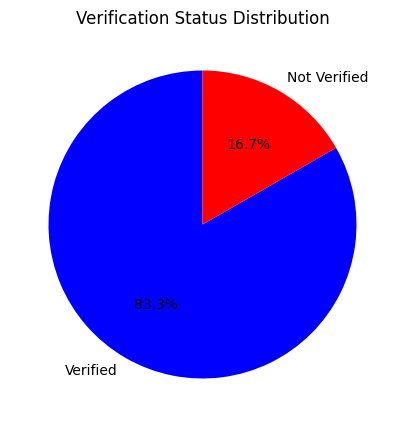

In [7]:
# Count the occurrences of each type
verification_counts = df['verified'].value_counts()

# Create labels for the pie chart
labels = ['Verified', 'Not Verified']

# Plot the pie chart
plt.figure(figsize=(5, 5))
plt.pie(verification_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
plt.title('Verification Status Distribution')
plt.show()

Next, we perform more data processing steps to obtain useful texts from the reviews:

1. Lowercasing:
Convert all text to lowercase to ensure consistency. This helps in treating words like "Word" and "word" as the same.

2. Removing Punctuation:
Remove punctuation marks as they often don't contribute much to the meaning of the text.

3. Tokenization:
Split the text into individual words or tokens. Tokenization is a crucial step for further processing.

4. Removing Stopwords:
Remove common stopwords (e.g., "the", "and", "is") that don't carry much meaning and are often excluded from analyses. We exclude words like "Not", "No", etc. as their existence is important to get the sentiment behind a customer's feedback.

5. Stemming or Lemmatization:
Reduce words to their base or root form. Stemming and lemmatization aim to normalize words, grouping variations of a word into a common base.

6. Removing Special Characters and Numbers:
Depending on your analysis, you might want to remove special characters and numbers if they are not relevant.

In [8]:
# Using the popular Natural Language Toolkit (nltk) library in Python
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}


def processing_reviews(review):
    # Lowercasing
    review = review.lower()

    # Removing Punctuation
    review = review.translate(str.maketrans("", "", string.punctuation))

    # Tokenization
    tokens = word_tokenize(review)

    # Removing Stopwords
    custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'nor', 'but', 'however', 'although', 'unless'}
    tokens = [token for token in tokens if token not in custom_stopwords]


    pos_tags = pos_tag(tokens)
    # Lemmatization (use WordNetLemmatizer)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=pos_dict.get(pos[0].upper(), wordnet.NOUN)) for token, pos in pos_tags]


    # Removing special characters and numbers
    tokens = [token for token in tokens if token.isalpha()]

    # Joining tokens back into cleaned text
    cleaned_review = ' '.join(tokens)

    return cleaned_review

# Apply the function to each row in the DataFrame
df['cleaned_reviews'] = df['reviews'].apply(processing_reviews)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [9]:
df.head()

,date,reviews,recommend,verified,cleaned_reviews
0,2024-02-02,We had possibly the worse check-in experience...,n,1.0,possibly worse checkin experience ever ever to...
1,2024-01-30,I flew to LHR from ATH in Club Europe with B...,y,1.0,flew lhr ath club europe dec transfer jal flig...
2,2024-01-29,I like the British Airways World Traveller P...,y,1.0,like british airways world traveller plus prod...
3,2024-01-28,I have come to boarding and my cabin luggage...,y,1.0,come boarding cabin luggage taken plane full a...
4,2024-01-26,Stinking nappies being changed in business ca...,n,1.0,stinking nappies changed business cabin throug...


## Sentiment Analysis
### VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool designed to analyze text and provide a sentiment polarity score. It is specifically tuned to work well with text from social media, which often includes informal language, slang, and emoticons.

Key features of VADER sentiment analysis include:

> **Polarity Scores**: VADER provides a compound sentiment polarity score ranging from -1 to 1, where negative scores indicate negative sentiment,
positive scores indicate positive sentiment, and a score of 0 indicates neutral sentiment.

> **Valence Aware**: VADER is designed to be "valence aware," meaning it understands and handles the intensity and polarity of sentiments in text. It recognizes variations in sentiment strength, intensity, and sentiment-boosting or sentiment-diminishing words.

> **Emoticon and Slang Handling**: VADER is capable of handling emoticons, slang, and other forms of informal language commonly found in social media text.

> **Word-Level Analysis**: VADER breaks down the sentiment analysis to the level of individual words. It considers the context of words and their impact on sentiment.

Works Without Training Data: Unlike some machine learning-based sentiment analysis approaches that require training on labeled data, VADER comes with a pre-built sentiment lexicon (dictionary) that includes sentiment scores for words.

In [10]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


In [11]:
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

# Calculating VADER sentiment scores
def vadersentimentanalysis(review):
    sentiment_score = analyzer.polarity_scores(review)
    return sentiment_score['compound']

df['sentiment_score'] = df['cleaned_reviews'].apply(vadersentimentanalysis)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [12]:
# Labeling the reviews
def vader_analysis(sentiment_score):
    if sentiment_score < 0:
        return 'Negative'
    elif sentiment_score >= 0.5:
        return 'Positive'
    else:
        return 'Neutral'

df['class'] = df['sentiment_score'].apply(vader_analysis)


In [13]:
df.head(10)

,date,reviews,recommend,verified,cleaned_reviews,sentiment_score,class
0,2024-02-02,We had possibly the worse check-in experience...,n,1.0,possibly worse checkin experience ever ever to...,0.7069,Positive
1,2024-01-30,I flew to LHR from ATH in Club Europe with B...,y,1.0,flew lhr ath club europe dec transfer jal flig...,0.9501,Positive
2,2024-01-29,I like the British Airways World Traveller P...,y,1.0,like british airways world traveller plus prod...,0.9637,Positive
3,2024-01-28,I have come to boarding and my cabin luggage...,y,1.0,come boarding cabin luggage taken plane full a...,-0.0387,Negative
4,2024-01-26,Stinking nappies being changed in business ca...,n,1.0,stinking nappies changed business cabin throug...,0.8848,Positive
5,2024-01-23,Worst service ever. Lost baggage because of d...,n,1.0,worst service ever lost baggage delayed flight...,-0.9648,Negative
6,2024-01-21,BA 246 21JAN 2023 Did not appreciate the unp...,n,1.0,ba not appreciate unprofessional attitude pilo...,0.5013,Positive
7,2024-01-18,Not a great experience. I could not check in ...,n,1.0,not great experience could not check online tw...,0.7405,Positive
8,2024-01-18,I was excited to fly BA as I'd not travelled ...,n,0.0,excited fly ba id not travelled long haul ive ...,0.5719,Positive
9,2024-01-17,I just want to warn everyone of the worst cu...,n,0.0,want warn everyone worst customer service expe...,-0.9444,Negative


## Visual representation

Plotting the percentage of reviewers recommending British Airlines

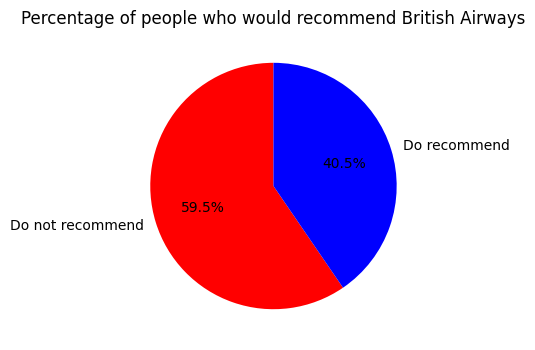

In [20]:
# Count the percentages of the reviews from each category
rec_counts = df['recommend'].value_counts()
# Create labels for the pie chart
labels = ['Do not recommend', 'Do recommend']

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(rec_counts , labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'blue'])
plt.title('Percentage of people who would recommend British Airways')
plt.show()

About 60% of the reviewers do not recommend considering the British Airways for flights.

---
Plotting the percentage of each category of reviews as predicted using VADER

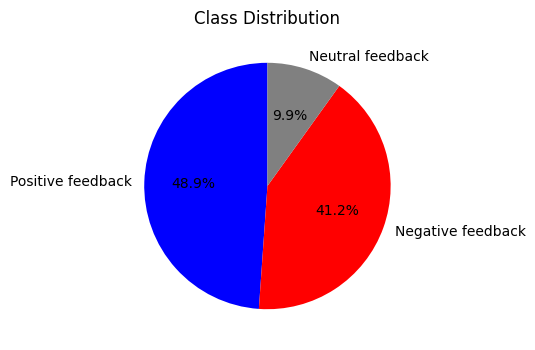

In [22]:
# Count the percentages of the reviews from each category
class_counts = df['class'].value_counts()

# Create labels for the pie chart
labels = ['Positive feedback', 'Negative feedback', 'Neutral feedback']

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_counts , labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red', 'grey'])
plt.title('Class Distribution')
plt.show()

---
Plotting the number of reviewers recommending or not British Airways in each category

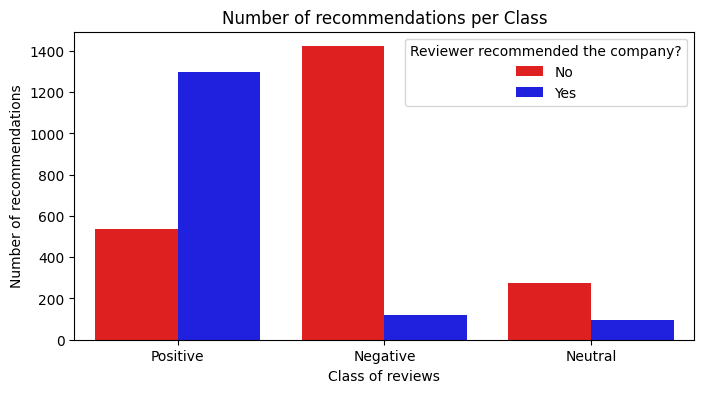

In [16]:
# Create a bar chart
plt.figure(figsize=(8, 4))
legend_labels = ['No','Yes']
sns.countplot(x='class', hue='recommend', data=df, palette={'y': 'blue', 'n': 'red'})
plt.title('Number of recommendations per Class')
plt.xlabel('Class of reviews')
plt.ylabel('Number of recommendations')
plt.legend(title='Reviewer recommended the company?', labels=legend_labels, loc='upper right')
plt.show()

---
Plotting the wordclouds of most frequent terms in positive and negative reviews

In [17]:
stopwords = set(STOPWORDS)

def show_wordcloud(reviews):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        #max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(reviews))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()


Wordcloud showing most frequent terms in positive reviews


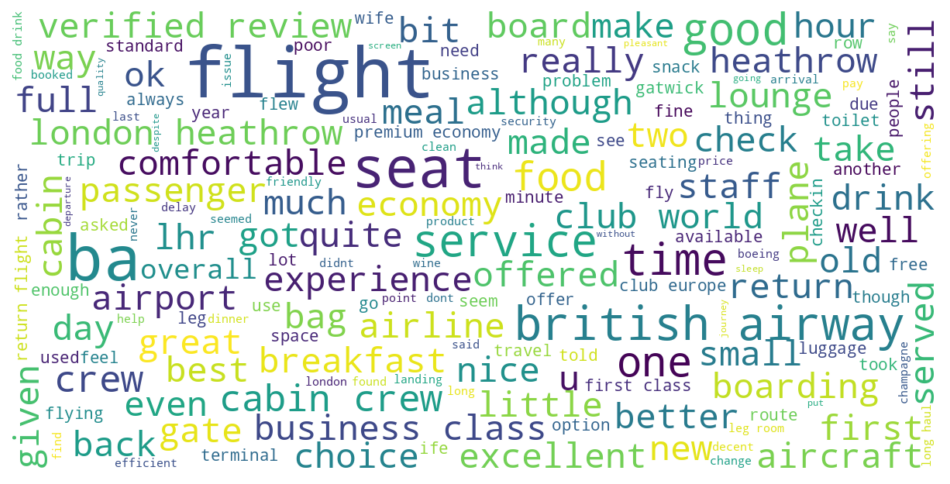

In [23]:
positive_reviews = df[df['class'] == 'Positive']
positive_data = " ".join(positive_reviews['cleaned_reviews'])
print("Wordcloud showing most frequent terms in positive reviews")
show_wordcloud(positive_data)

Wordcloud showing most frequent terms in negative reviews


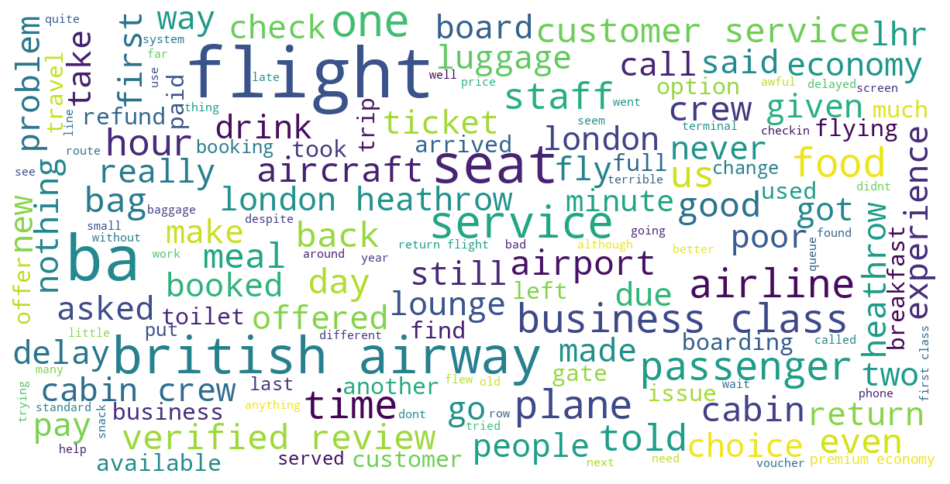

In [24]:
negative_reviews = df[df['class'] == 'Negative']
negative_data = " ".join(negative_reviews['cleaned_reviews'])
print("Wordcloud showing most frequent terms in negative reviews")
show_wordcloud(negative_data)